In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
import scipy.misc
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
from unet import UNet

seed = 0
np.random.seed(seed)
torch.manual_seed(seed);

In [2]:
device = torch.device('cpu')

In [3]:
class DataAugmentation:
    def __init__(self,input_size=572):
        self.input_size = input_size
        pass
    
    def randomFlip(self,image, label):
        if random.randint(0, 1) == 1:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            label = label.transpose(Image.FLIP_LEFT_RIGHT)
        if random.randint(0, 1) == 1:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            label = label.transpose(Image.FLIP_TOP_BOTTOM)
        return image,label
    
    def randomRotation(self,image, label, mode=Image.BICUBIC):
        if random.randint(0, 1) == 1:
            random_angle = np.random.randint(1, 360)
            image = image.rotate(random_angle, mode)
            label = label.rotate(random_angle, Image.NEAREST)
        return image,label
    
    
    def randomResizedCrop(self,image, label, resized_ratio=(0.2,1.0)):
        crop_size = self.input_size
        image_width = image.size[0]
        image_height = image.size[1]
        if random.randint(0, 1) == 1:
            size_resize = random.randint(int(crop_size/resized_ratio[1]+1),int(crop_size/resized_ratio[0]))
        else:
            size_resize = crop_size+1
        image = transforms.Resize(size_resize, interpolation=Image.BICUBIC)(image)
        lable = transforms.Resize(size_resize, interpolation=Image.NEAREST)(label)
        
        
        image_width = image.size[0]
        image_height = image.size[1]
        crop_left = random.randint(0,int(image_width-crop_size-1))
        crop_up = random.randint(0,int(image_height-crop_size-1))
        
        crop_box = (crop_left,crop_up,crop_left+crop_size,crop_up+crop_size)
        image = image.crop(crop_box)
        lable = lable.crop(crop_box)
        
        return image,lable
    
    def test_Resized(self,image, label):
        crop_size = self.input_size
        width = image.size[0]
        height = image.size[1]
        desired_size = max(width,height)
        new_im = Image.new("RGB", (desired_size, desired_size))
        new_im.paste(image)
        new_mask = Image.new("1", (desired_size, desired_size))
        new_mask.paste(label)
        image = transforms.Resize(crop_size, interpolation=Image.BICUBIC)(new_im)
        lable = transforms.Resize(crop_size, interpolation=Image.NEAREST)(new_mask)
        return image,lable
        
    
    def randomGaussian(self,image, label, mean=0.2, sigma=0.3):
        def gaussianNoisy(im, mean=0.2, sigma=0.3):
            for _i in range(len(im)):
                im[_i] += random.gauss(mean, sigma)
            return im

        img = np.asarray(image).copy()
        img.flags.writeable = True
        width, height = img.shape[:2]
        img_r = gaussianNoisy(img[:, :, 0].flatten(), mean, sigma)
        img_g = gaussianNoisy(img[:, :, 1].flatten(), mean, sigma)
        img_b = gaussianNoisy(img[:, :, 2].flatten(), mean, sigma)
        img[:, :, 0] = img_r.reshape([width, height])
        img[:, :, 1] = img_g.reshape([width, height])
        img[:, :, 2] = img_b.reshape([width, height])
        return Image.fromarray(np.uint8(img)), label
        
        
    def randomColor(self,image, label):
        image = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0)(image)
        return image,label
    
    def Normalization(self,image, label):
        image = transforms.ToTensor()(image)
        image = transforms.Normalize([0.4373, 0.4434, 0.4725],[0.1201, 0.1231, 0.1052])(image)
        label = transforms.ToTensor()(label)
        return image,label
    
    def randomCover(self,image, label,cover=128):
        if random.randint(0, 1) == 1:
            image_width = image.size(1)
            image_height = image.size(2)

            cover_left = random.randint(0,int(image_width-cover-1))
            cover_up = random.randint(0,int(image_height-cover-1))

            image[:,cover_left:(cover_left+cover),cover_up:(cover_up+cover)]=0
            label[:,cover_left:(cover_left+cover),cover_up:(cover_up+cover)]=0
        return image,label
    
    def TrainAugmentation(self,image,label):
        new_image,new_label = self.randomFlip(image,label)
        new_image,new_label = self.randomRotation(new_image,new_label)
        new_image,new_label = self.randomResizedCrop(new_image,new_label)
        new_image,new_label = self.randomGaussian(new_image,new_label)
        new_image,new_label = self.randomColor(new_image,new_label)
        new_image,new_label = self.Normalization(new_image,new_label)
        #new_image,new_label = self.randomCover(new_image,new_label)
        return new_image,new_label
    
    def TestProcess(self,image,label):
        new_image,new_label = self.test_Resized(image, label)
        new_image,new_label = self.Normalization(new_image,new_label)
        return new_image,new_label

In [4]:
class image_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        image_name = self.df.iloc[idx]['image']
        image_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/segmentation/images_preprocessed/'\
        + image_name
        mask_name = self.df.iloc[idx]['mask']
        mask_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/segmentation/mask_preprocessed/'\
        + mask_name
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        if self.train:
            new_image,new_label = DataAugmentation().TrainAugmentation(image,mask)
        else:
            new_image,new_label = DataAugmentation().TestProcess(image,mask)
        
        sample={'x':new_image,'y':new_label}
        return sample

In [5]:
train_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/seg_train.csv'
val_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/seg_val.csv'
test_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/seg_test.csv'
BATCH_SIZE = 1
train_loader = DataLoader(image_dataset(train_df_path,train = True), batch_size=BATCH_SIZE, shuffle=True,num_workers=1)
val_loader = DataLoader(image_dataset(val_df_path), batch_size=BATCH_SIZE, shuffle=True,num_workers=8)
test_loader = DataLoader(image_dataset(test_df_path), batch_size=BATCH_SIZE, shuffle=False,num_workers=8)


In [6]:
#image_tensor = next(iter(train_loader))['x'][0]

In [7]:
'''inv_normalize = transforms.Normalize(mean=[-0.4373/0.1201, -0.4434/0.1231, -0.4725/0.1052],\
                                     std=[1/0.1201, 1/0.1231, 1/0.1052])
image = inv_normalize(image_tensor)
transforms.ToPILImage()(image)'''

'inv_normalize = transforms.Normalize(mean=[-0.4373/0.1201, -0.4434/0.1231, -0.4725/0.1052],                                     std=[1/0.1201, 1/0.1231, 1/0.1052])\nimage = inv_normalize(image_tensor)\ntransforms.ToPILImage()(image)'

In [8]:
#sample = next(iter(train_loader))

In [9]:
#sample_x = sample['x']

In [10]:
#sample_x.size()

In [11]:
#sample['y'].size()

In [12]:
model = UNet()

In [13]:
path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/unet/unet_carvana_scale1_epoch5.pth'
model.load_state_dict(torch.load(path,map_location=device))

<All keys matched successfully>

In [14]:
#sample_x.size()

In [15]:
#model(sample_x).size()

In [16]:
class BCE_IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCE_IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
        IoU_loss  = 1 - IoU
        
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        BCE_IoU_loss = IoU_loss+BCE_loss
                
        return BCE_IoU_loss

In [17]:
class IoU_metric(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU_metric, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = torch.sigmoid(inputs)  
        inputs = torch.round(inputs)
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

In [18]:
lr = 0.001
loss_fn = BCE_IoULoss()
metric = IoU_metric()

In [19]:
def train(model, train_loader=train_loader, val_loader=val_loader, learning_rate=5e-5, num_epoch=1000,\
          lr=lr,loss_fn=loss_fn,metric=metric):
    start_time = time.time()
    
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max', patience=2)
    
    
    train_loss_return = []
    train_iou_return = []
    val_loss_return = []
    val_iou_return = []
    best_iou = 0
    
    for epoch in range(num_epoch):
        # Training steps
        train_loss_list = []
        train_iou_list = []
        
        model.train()
        for i, (sample) in enumerate(train_loader):
            image = sample['x'].to(device)
            labels = sample['y'].to(device)
            outputs = model(image)
            model.zero_grad()
            loss = loss_fn(outputs, labels)
            iou = metric(outputs, labels)
            print(loss)
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.item())
            train_iou_list.append(iou.item())
            
        # report performance
        train_iou_every_epoch = np.average(train_iou_list)
        train_iou_return.append(train_iou_every_epoch)
        train_loss_every_epoch = np.average(train_loss_list)
        train_loss_return.append(train_loss_every_epoch)
        print('----------Epoch{:2d}/{:2d}----------'.format(epoch+1,num_epoch))
        print('Train set | Loss: {:6.6f} | IoU: {:4.4f}% '.format(train_loss_every_epoch, train_iou_every_epoch*100))
        
        # Evaluate after every epochh
        model.eval()
        val_loss_list = []
        val_iou_list = []
        
        
        with torch.no_grad():
            for i, (sample) in enumerate(val_loader):
                image = sample['x'].to(device)
                labels = sample['y'].to(device)
                outputs = model(image)
                loss = loss_fn(outputs, labels)
                iou = metric(outputs, labels)
                val_loss_list.append(loss.item())
                val_iou_list.append(iou.item())
            # report performance
            val_iou_every_epoch = np.average(val_iou_list)
            val_iou_return.append(val_iou_every_epoch)
            val_loss_every_epoch = np.average(val_loss_list)
            val_loss_return.append(val_loss_every_epoch)
            
            if val_iou_every_epoch > best_iou:
                best_iou = val_iou_every_epoch
                best_model_wts = model.state_dict()
            
            save_model(model,train_loss_return,train_iou_return,val_loss_return,val_iou_return,best_model_wts)
            
            elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
            print('Test set | Loss: {:6.6f} | IoU: {:4.4f}% | time elapse: {:>9}'\
                  .format(val_loss_every_epoch, val_iou_every_epoch*100,elapse))
    return model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts

def save_model(model,train_loss_return,train_iou_return,val_loss_return,val_iou_return,best_model_wts):
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_iou':train_iou_return,\
             'val_loss':val_loss_return, 'val_iou':val_iou_return}
    torch.save(state, 'checkpoint_UNet.pt')
    return None

In [20]:
model = model.to(device)

In [21]:
train(model)

tensor(2.7833, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.3505, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.4788, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2818, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1102, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8968, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2708, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2902, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9819, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3319, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9148, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8848, device='cuda:0', grad_fn=<AddBack

KeyboardInterrupt: 

In [22]:
path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/py files/UNet/Second_Train/checkpoint_UNet.pt'
model.load_state_dict(torch.load(path,map_location=device)['best_model_wts'])

<All keys matched successfully>

In [61]:
test_loader = DataLoader(image_dataset(test_df_path), batch_size=1, shuffle=True,num_workers=1)
sample = next(iter(test_loader))
sample_x = sample['x']
sample_y = sample['y']

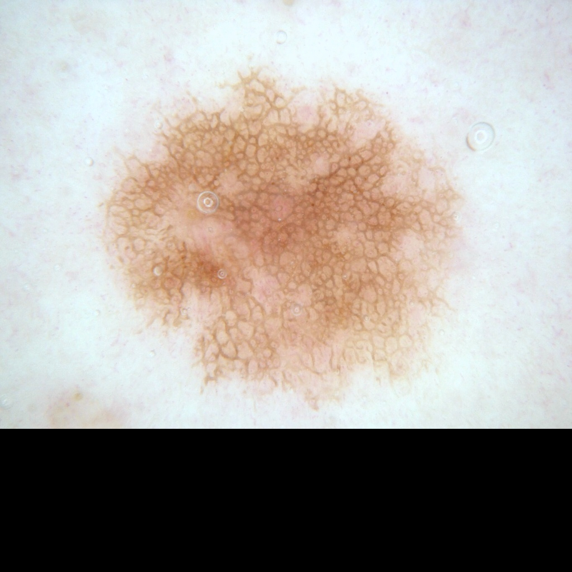

In [62]:
inv_normalize = transforms.Normalize(mean=[-0.4373/0.1201, -0.4434/0.1231, -0.4725/0.1052],\
                                     std=[1/0.1201, 1/0.1231, 1/0.1052])
image = inv_normalize(sample_x[0])
transforms.ToPILImage()(image)

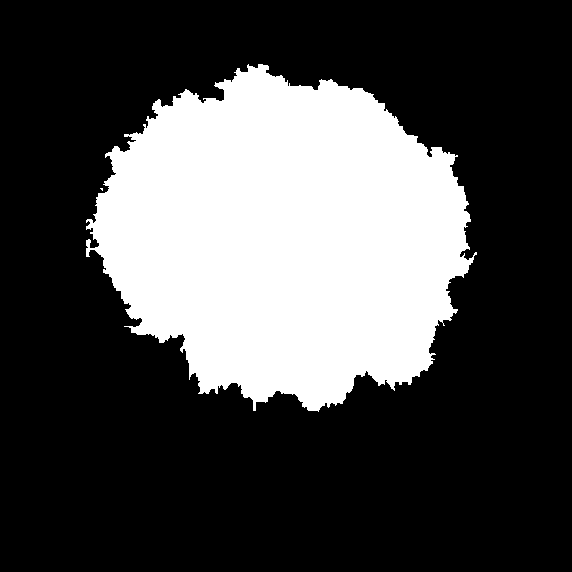

In [63]:
transforms.ToPILImage()(sample_y[0])

In [64]:
result = model(sample_x)

In [65]:
result_image = torch.sigmoid(result[0])
result_image = torch.round(result_image)

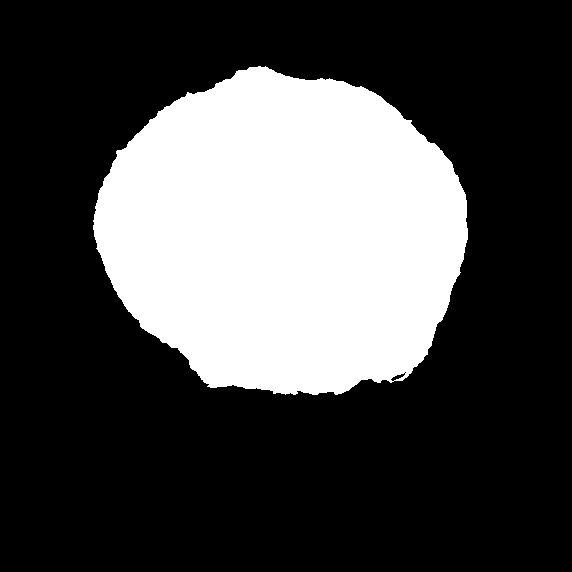

In [66]:
transforms.ToPILImage()(result_image)